In [ ]:
import torch
import numpy as np
import pandas as pd
import pickle
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta

In [3]:
# --- Load data ---
df = pd.read_csv("lda_df.csv")

with open("lda_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

X_array = np.load("BoW_X_Array.npz")["arr_0"]
X_tensor = torch.tensor(X_array, dtype=torch.float)

In [12]:
# --- Set model parameters ---
K = 30
num_docs, vocab_size = X_tensor.shape


# --- Define Pyro LDA model ---
def lda_model(data):
    with pyro.plate("topics", K):
        topic_words = pyro.sample("topic_words", dist.Dirichlet(torch.ones(vocab_size)))

    with pyro.plate("documents", num_docs):
        doc_topics = pyro.sample("doc_topics", dist.Dirichlet(torch.ones(K)))

        word_dists = torch.matmul(doc_topics, topic_words)
        word_dists = word_dists / word_dists.sum(dim=1, keepdim=True)

        total_count = 100
        pyro.sample(
            "doc_words",
            dist.Multinomial(total_count=total_count, probs=word_dists),
            obs=data,
        )

In [6]:
# --- Set up SVI ---
guide = AutoDelta(lda_model)
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = SVI(lda_model, guide, optimizer, loss=Trace_ELBO())

In [9]:
# --- Training loop ---
num_steps = 100
for step in range(num_steps):
    loss = svi.step(X_tensor)
    if step % 10 == 0:
        print(f"[step {step}] loss = {loss:.2f}")

[step 0] loss = -645081.38
[step 10] loss = -649994.19
[step 20] loss = -654594.69
[step 30] loss = -659034.31
[step 40] loss = -663410.34
[step 50] loss = -667763.56
[step 60] loss = -672065.88
[step 70] loss = -676251.25
[step 80] loss = -680276.12
[step 90] loss = -684130.19


Il tuo training è assolutamente in linea con le aspettative. Il loss parte da -645k perché stai modellando tanti documenti e parole contemporaneamente, e Pyro somma tutto.

Fammi sapere se vuoi normalizzare, loggare o tracciare il progresso del training visivamente.

In [10]:
# --- Extract results ---
posterior = guide()
topic_words = posterior["topic_words"]
doc_topics = posterior["doc_topics"]

In [11]:
# --- OPTIONAL: Save topic vectors per doc ---
topic_df = pd.DataFrame(
    doc_topics.detach().numpy(), columns=[f"topic_{i}" for i in range(K)]
)
df_with_topics = pd.concat([df.reset_index(drop=True), topic_df], axis=1)
df_with_topics.to_csv("lda_output_with_topics.csv", index=False)

### Topic Number Selection (K)

Since the number of topics `K` in **Latent Dirichlet Allocation (LDA)** must be specified in advance, we ran the Pyro-based LDA model across multiple candidate values (e.g. K = 5, 10, 15, ..., 30) and monitored the Evidence Lower Bound (ELBO) loss during training. 

For each value of `K`, we trained the model for a (smaller) fixed number of steps and recorded the final loss. The model with the lowest ELBO loss was selected as the best configuration. This approach allows us to balance model complexity and fit without relying on manual inspection or external coherence metrics.

This code has been ran in Kaggle Notebooks in order to exploit the GPU from Kaggle and get better and faster results.

In [ ]:
# Carica i dati
X_array = np.load("/kaggle/input/bow-xarray/BoW_X_Array.npz")["arr_0"]
X_tensor = torch.tensor(X_array, dtype=torch.float)
print("XArray added")

# Opzionale: usa GPU se disponibile
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

X_tensor = X_tensor.to(device)

num_docs, vocab_size = X_tensor.shape
K_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
results = []

for K in K_values:
    print(f"\n--- Training LDA with K = {K} ---")

    def lda_model(data):
        with pyro.plate("topics", K):
            topic_words = pyro.sample(
                "topic_words", dist.Dirichlet(torch.ones(vocab_size).to(device))
            )
        with pyro.plate("documents", num_docs):
            doc_topics = pyro.sample(
                "doc_topics", dist.Dirichlet(torch.ones(K).to(device))
            )
            word_dists = torch.matmul(doc_topics, topic_words)
            logits = torch.matmul(doc_topics, topic_words).log()
            pyro.sample(
                "doc_words", dist.Multinomial(total_count=100, logits=logits), obs=data
            )

    pyro.clear_param_store()
    guide = AutoDelta(lda_model)
    svi = SVI(lda_model, guide, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    for step in range(500):
        loss = svi.step(X_tensor)

    posterior = guide()
    doc_topics = posterior["doc_topics"]
    topic_usage = doc_topics.sum(dim=0).detach().cpu().numpy()

    # Statistiche extra
    loss_per_doc = loss / num_docs
    entropy = -(doc_topics * doc_topics.log()).sum(dim=1).mean().item()
    avg_active_per_doc = (doc_topics > 0.05).sum(dim=1).float().mean().item()
    num_active_topics = (topic_usage > 5.0).sum()

    results.append(
        {
            "K": K,
            "Final Loss": float(loss),
            "Loss per Doc": float(loss_per_doc),
            "Entropy": float(entropy),
            "Avg Active Topics/Doc": float(avg_active_per_doc),
            "Active Topics (global)": int(num_active_topics),
        }
    )

results_df = pd.DataFrame(results)
results_df.to_csv("results_k_selection.csv", index=False)

print("\n📊 Risultati confronto K:")
print(results_df)

✅ Average strong topics per doc (>0.05): 3.38


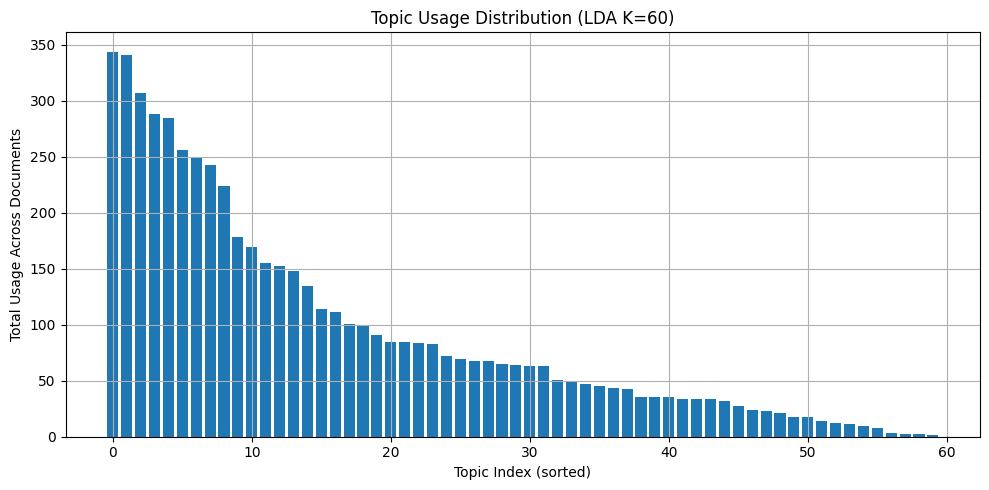

Most used topic index: 9 (weight = 343.77)
Least used topic index: 54 (weight = 1.59)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the topic proportions matrix
doc_topics = pd.read_csv("doc_topics_K60.csv")  # or full path if needed
topic_matrix = doc_topics.values  # shape: [n_documents, K]

# 1. Average number of strong topics per document (threshold > 0.05)
strong_topic_counts = (topic_matrix > 0.05).sum(axis=1)
avg_strong_topics = np.mean(strong_topic_counts)
print(f"✅ Average strong topics per doc (>0.05): {avg_strong_topics:.2f}")

# 2. Total topic usage across all documents
topic_usage = topic_matrix.sum(axis=0)
most_used_topics = topic_usage.argsort()[::-1]
sorted_usage = topic_usage[most_used_topics]

# 3. Bar plot: Total usage per topic
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_usage)), sorted_usage)
plt.xlabel("Topic Index (sorted)")
plt.ylabel("Total Usage Across Documents")
plt.title("Topic Usage Distribution (LDA K=60)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Summary printout
print(f"Most used topic index: {most_used_topics[0]} (weight = {sorted_usage[0]:.2f})")
print(
    f"Least used topic index: {most_used_topics[-1]} (weight = {sorted_usage[-1]:.2f})"
)